In [1]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pathlib import Path

import xtrack as xt
import xcoll as xc

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self['data'].fields:
            for i, bpm in enumerate(self['data'][crate]['ChannelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self['data'][crate]['Positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [3]:
bpm_path = Path('/Users/lisepauwels/sps_simulations/MD_data/20251010/bpms/')

In [4]:
file_names = {'REF_MICADO_CORR_NEG': ["2025-10-10T12_10_49.parquet", "2025-10-10T12_11_07.parquet", "2025-10-10T12_11_25.parquet"],
              'REF_MICADO_CORR_POS': ["2025-10-10T12_13_13.parquet", "2025-10-10T12_13_31.parquet", "2025-10-10T12_13_49.parquet"],
              'REF_NO_CORR_NEG' : ["2025-10-10T11_25_42.parquet", "2025-10-10T11_26_00.parquet", "2025-10-10T11_27_30.parquet"],
              'REF_NO_CORR_POS' : ["2025-10-10T11_58_49.parquet", "2025-10-10T11_59_07.parquet", "2025-10-10T11_59_25.parquet"],
              'REF_ZERO_CORR_NEG': ["2025-10-10T11_34_42.parquet", "2025-10-10T11_35_00.parquet", "2025-10-10T11_35_18.parquet"],
              'REF_ZERO_CORR_POS': ["2025-10-10T11_53_07.parquet", "2025-10-10T11_53_25.parquet", "2025-10-10T11_53_43.parquet"],
              'REF_SVD_CORR_1.2_0.8_NEG' : ["2025-10-10T12_50_17.parquet", "2025-10-10T12_50_28.parquet", "2025-10-10T12_50_46.parquet"],
              'REF_SVD_CORR_1.2_0.8_POS' : ["2025-10-10T12_48_04.parquet", "2025-10-10T12_48_22.parquet", "2025-10-10T12_48_40.parquet"],
              'REF_SVD_CORR_1.2_1.6_NEG' : ["2025-10-10T13_35_28.parquet", "2025-10-10T13_35_46.parquet", "2025-10-10T13_36_04.parquet"],
              'REF_SVD_CORR_1.2_1.6_POS' : ["2025-10-10T13_33_58.parquet", "2025-10-10T13_34_16.parquet", "2025-10-10T13_34_34.parquet"],
              'REF_SVD_CORR_2.1_0.8_NEG' : ["2025-10-10T12_54_04.parquet", "2025-10-10T12_54_22.parquet", "2025-10-10T12_54_40.parquet"],
              'REF_SVD_CORR_2.1_0.8_POS' : ["2025-10-10T12_56_46.parquet", "2025-10-10T12_57_04.parquet", "2025-10-10T12_57_22.parquet"],
              'REF_SVD_CORR_2.2_1.5_NEG' : ["2025-10-10T13_39_21.parquet", "2025-10-10T13_39_39.parquet", "2025-10-10T13_39_57.parquet"],
              'REF_SVD_CORR_2.2_1.5_POS' : ["2025-10-10T13_17_10.parquet", "2025-10-10T13_17_28.parquet", "2025-10-10T13_17_46.parquet"]}

In [5]:
bpms_data = {}
for key in file_names:
    print(key)
    bpms_data[key] = []
    for filename in file_names[key]:
        print(filename)
        if filename in  ['2025-10-10T12_50_17.parquet'] or key in ['REF_SVD_CORR_2.2_1.5_NEG']: #For some reason these files give errors when loading.
            continue
        bpms_data[key].append(ak.Array(ak.from_parquet(Path(bpm_path, filename)),with_name='BPMCollection'))

    print(' ')

REF_MICADO_CORR_NEG
2025-10-10T12_10_49.parquet
2025-10-10T12_11_07.parquet
2025-10-10T12_11_25.parquet
 
REF_MICADO_CORR_POS
2025-10-10T12_13_13.parquet
2025-10-10T12_13_31.parquet
2025-10-10T12_13_49.parquet
 
REF_NO_CORR_NEG
2025-10-10T11_25_42.parquet
2025-10-10T11_26_00.parquet
2025-10-10T11_27_30.parquet
 
REF_NO_CORR_POS
2025-10-10T11_58_49.parquet
2025-10-10T11_59_07.parquet
2025-10-10T11_59_25.parquet
 
REF_ZERO_CORR_NEG
2025-10-10T11_34_42.parquet
2025-10-10T11_35_00.parquet
2025-10-10T11_35_18.parquet
 
REF_ZERO_CORR_POS
2025-10-10T11_53_07.parquet
2025-10-10T11_53_25.parquet
2025-10-10T11_53_43.parquet
 
REF_SVD_CORR_1.2_0.8_NEG
2025-10-10T12_50_17.parquet
2025-10-10T12_50_28.parquet
2025-10-10T12_50_46.parquet
 
REF_SVD_CORR_1.2_0.8_POS
2025-10-10T12_48_04.parquet
2025-10-10T12_48_22.parquet
2025-10-10T12_48_40.parquet
 
REF_SVD_CORR_1.2_1.6_NEG
2025-10-10T13_35_28.parquet
2025-10-10T13_35_46.parquet
2025-10-10T13_36_04.parquet
 
REF_SVD_CORR_1.2_1.6_POS
2025-10-10T13_33_5

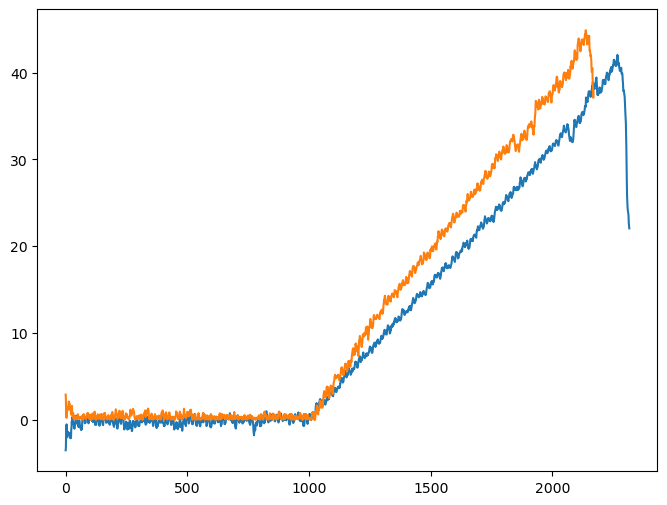

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(bpms_data['REF_MICADO_CORR_POS'][0].hor_turn_position[0] - np.nanmean(bpms_data['REF_MICADO_CORR_POS'][0].hor_turn_position[0][500:1015]))
ax.plot(abs(bpms_data['REF_MICADO_CORR_NEG'][0].hor_turn_position[0] - np.nanmean(bpms_data['REF_MICADO_CORR_NEG'][0].hor_turn_position[0][500:1015])))

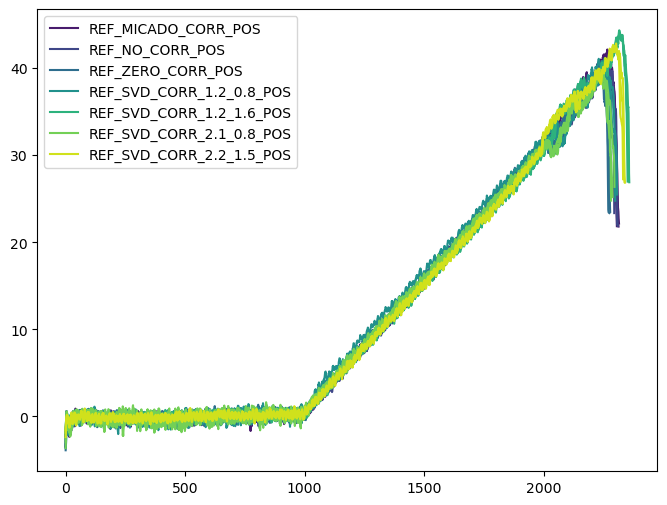

In [7]:
from turtle import color


fig, ax = plt.subplots(1,1, figsize=(8,6))
colormap = colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
for n, key in enumerate(list(bpms_data.keys())):
    if 'POS' in key:
        color = colormap(norm(n))
        #for i in range(1, len(bpms_data[key])):
        for i in range(len(bpms_data[key])):
            if i == 0:
                #ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015]), label=f'{key}', color=color)
                ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][50:1015]), label=f'{key}', color=color)

            else:
                ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][50:101]), color=color)
ax.legend()

# Reconstructing dispersion factors - code development

## Second order

In [8]:
start_idx = 1015

In [9]:
def fit_pooled(x, ys, deg):
    # ys: list/tuple of arrays [y1, y2, ...], each same length as x
    X = np.concatenate([x]*len(ys))             # length n = m * num_sets
    Y = np.concatenate(ys)
    coefs = np.polyfit(X, Y, deg)               # ordinary least squares
    Yfit = np.polyval(coefs, X)
    RSS = np.sum((Y - Yfit)**2)
    n = len(Y)
    k = deg + 1
    bic = k*np.log(n) + n*np.log(RSS / n)
    return coefs, RSS, bic

In [10]:
dat

NameError: name 'dat' is not defined

In [ ]:
500/10

50.0

In [11]:
line = xt.Line.from_json('/Users/lisepauwels/sps_simulations/injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tw = line.twiss()
def dr_to_delta(dr, tw):
    R0 = line.get_length() / (2 * np.pi)
    delta = dr/ R0 * 1/tw.momentum_compaction_factor
    return delta

def df_to_delta(df, tw):
    f0 = 200e6
    delta = - 1/tw.slip_factor * df /f0 
    return delta

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [12]:
dispersion_factors = {}
injection_idx = int(500/10)
start_idx = 1015#int(1015/10)
t_sweep = 1.67
for key in bpms_data:
    dispersion_factors[key] = {}

    if key in ['REF_SVD_CORR_2.2_1.5_NEG']:
        continue
    for nn_bpm, bpm in enumerate(bpms_data[key][0].bpms_hor):
        dispersion_factors[key][bpm] = []
        idx_max = np.argmax(bpms_data[key][0].hor_turn_position[nn_bpm])
        if idx_max < start_idx:
            print(key, bpm)
            continue
        dat = []
        c = 0
        for i in range(len(bpms_data[key])):
            if len(bpms_data[key][i].hor_turn_position[nn_bpm][start_idx:idx_max]) == 0 or np.isnan(np.unique(bpms_data[key][i].hor_turn_position[nn_bpm])[0]):
                c +=1
            else:
                dat.append(bpms_data[key][i].hor_turn_position[nn_bpm][start_idx:idx_max] - np.nanmean(bpms_data[key][i].hor_turn_position[nn_bpm][injection_idx:start_idx]))
        if c == 3:
            print(key, bpm)
        
        else:
            dr_sweep = np.linspace(0, 32e-3, idx_max-start_idx)
            delta_sweep = dr_to_delta(dr_sweep, tw)
            coefs, RSS, bic = fit_pooled(delta_sweep, dat, deg=2)
            dispersion_factors[key][bpm] = coefs
    # if 'POS' in key:
    #     dispersion_factors[key] = []
    #     for i in range(len(bpms_data[key])):
    #         delta_pos = bpms_data[key][i].hor_turn_position[0][start_idx:] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015])
    #         if i == 0:
    #             ref_pos = delta_pos
    #         dispersion = delta_pos / ref_pos
    #         dispersion_factors[key].append(dispersion)

REF_MICADO_CORR_NEG bph.10208
REF_MICADO_CORR_NEG bph.10408
REF_MICADO_CORR_NEG bph.10608
REF_MICADO_CORR_NEG bph.10808
REF_MICADO_CORR_NEG bph.11008
REF_MICADO_CORR_NEG bph.11208
REF_MICADO_CORR_NEG bph.11408
REF_MICADO_CORR_NEG bph.12208
REF_MICADO_CORR_NEG bph.12408
REF_MICADO_CORR_NEG bph.12608
REF_MICADO_CORR_NEG bph.12808
REF_MICADO_CORR_NEG bph.13008
REF_MICADO_CORR_NEG bph.13208
REF_MICADO_CORR_NEG bph.13408
REF_MICADO_CORR_NEG bph.13608
REF_MICADO_CORR_NEG bph.20208
REF_MICADO_CORR_NEG bph.20408
REF_MICADO_CORR_NEG bph.20608
REF_MICADO_CORR_NEG bph.20808
REF_MICADO_CORR_NEG bph.21008
REF_MICADO_CORR_NEG bph.21208
REF_MICADO_CORR_NEG bph.21408
REF_MICADO_CORR_NEG bph.22008
REF_MICADO_CORR_NEG bph.22208
REF_MICADO_CORR_NEG bph.22408
REF_MICADO_CORR_NEG bph.22608
REF_MICADO_CORR_NEG bph.22808
REF_MICADO_CORR_NEG bph.23008
REF_MICADO_CORR_NEG bph.23208
REF_MICADO_CORR_NEG bph.23408
REF_MICADO_CORR_NEG bph.23608
REF_MICADO_CORR_NEG bph.30208
REF_MICADO_CORR_NEG bph.30408
REF_MICADO

In [13]:
dispersion_factors

{'REF_MICADO_CORR_NEG': {'bph.10208': [],
  'bph.10408': [],
  'bph.10608': [],
  'bph.10808': [],
  'bph.11008': [],
  'bph.11208': [],
  'bph.11408': [],
  'bph.11608': <Array [4.21e+04, 157, 0.149] type='3 * float64'>,
  'bph.11831': <Array [5.7e+04, 591, -2.37] type='3 * float64'>,
  'bph.12008': <Array [nan, nan, nan] type='3 * float64'>,
  'bph.12208': [],
  'bph.12408': [],
  'bph.12608': [],
  'bph.12808': [],
  'bph.13008': [],
  'bph.13208': [],
  'bph.13408': [],
  'bph.13608': [],
  'bph.20208': [],
  'bph.20408': [],
  'bph.20608': [],
  'bph.20808': [],
  'bph.21008': [],
  'bph.21208': [],
  'bph.21408': [],
  'bph.22008': [],
  'bph.22208': [],
  'bph.22408': [],
  'bph.22608': [],
  'bph.22808': [],
  'bph.23008': [],
  'bph.23208': [],
  'bph.23408': [],
  'bph.23608': [],
  'bph.30208': [],
  'bph.30408': [],
  'bph.30608': [],
  'bph.30808': [],
  'bph.31008': [],
  'bph.31208': [],
  'bph.31408': [],
  'bph.31608': <Array [1.46e+03, 18, 0.0613] type='3 * float64'>,

p(x) = p[0] * x**deg + ... + p[deg]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(bpms_data['REF_MICADO_CORR_POS'][0].hor_turn_position[0] - np.nanmean(bpms_data['REF_MICADO_CORR_POS'][0].hor_turn_position[0][50:101]))
ax.plot(0.324 + -0.00806*np.arange())

In [ ]:
np.arange(len(dat[0]))

array([   0,    1,    2, ..., 2196, 2197, 2198], shape=(2199,))

In [ ]:
t_sweep = 1.67
dr_sweep = np.linspace(0, 32e-3, 1670)
delta_sweep = dr_to_delta(dr_sweep, tw)

In [ ]:
delta_sweep[1000]

np.float64(0.005613737698834267)

In [ ]:
dr_sweep

array([0.])

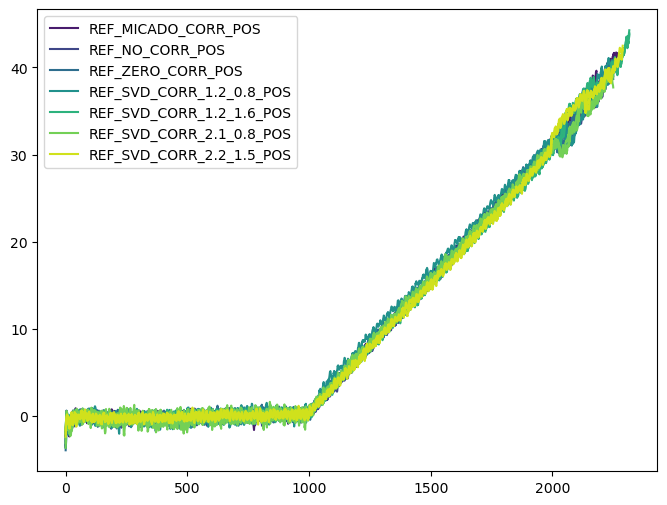

In [14]:
t_sweep = 1.67

fig, ax = plt.subplots(1,1, figsize=(8,6))
colormap = colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
for n, key in enumerate(list(bpms_data.keys())):
    if 'POS' in key:
        color = colormap(norm(n))
        #for i in range(1, len(bpms_data[key])):
        idx_max = np.argmax(bpms_data[key][0].hor_turn_position[0])
        start_idx = 0#1015#int(1015/10)
        dr_sweep = np.linspace(0, 32e-3, idx_max-start_idx)
        delta_sweep = dr_to_delta(dr_sweep, tw)
        for i in range(len(bpms_data[key])):
            if i == 0:
                #ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015]), label=f'{key}', color=color)
                ax.plot(bpms_data[key][i].hor_turn_position[0][start_idx:idx_max] - np.nanmean(bpms_data[key][i].hor_turn_position[0][50:101]), label=f'{key}', color=color)

            else:
                ax.plot(bpms_data[key][i].hor_turn_position[0][start_idx:idx_max] - np.nanmean(bpms_data[key][i].hor_turn_position[0][50:101]), color=color)
ax.legend()

# BPM analysis

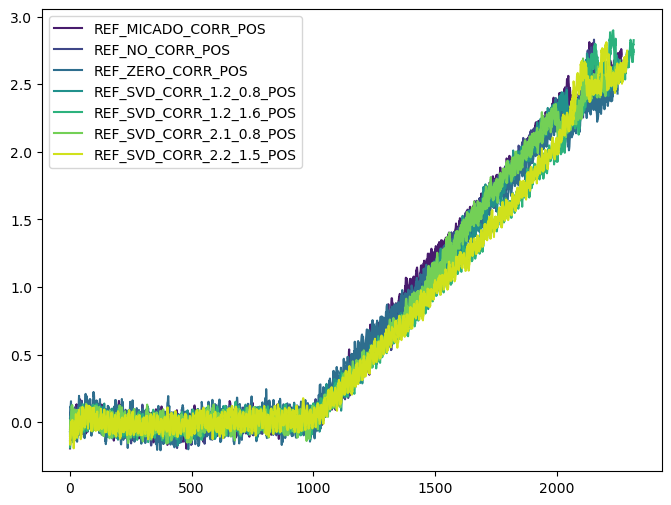

In [24]:
t_sweep = 1.67

fig, ax = plt.subplots(1,1, figsize=(8,6))
colormap = colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
bpm_number = 1
for n, key in enumerate(list(bpms_data.keys())):
    if 'POS' in key:
        color = colormap(norm(n))
        #for i in range(1, len(bpms_data[key])):
        idx_max = np.argmax(bpms_data[key][0].hor_turn_position[0])
        start_idx = 0#1015#int(1015/10)
        dr_sweep = np.linspace(0, 32e-3, idx_max-start_idx)
        delta_sweep = dr_to_delta(dr_sweep, tw)
        for i in range(len(bpms_data[key])):
            if i == 0:
                #ax.plot(bpms_data[key][i].hor_turn_position[0] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015]), label=f'{key}', color=color)
                ax.plot((bpms_data[key][i].hor_turn_position[bpm_number][start_idx:idx_max] - np.nanmean(bpms_data[key][i].hor_turn_position[bpm_number][0:1000]))/tw.rows['bph.10208'].dx[0], label=f'{key}', color=color)

            else:
                ax.plot((bpms_data[key][i].hor_turn_position[bpm_number][start_idx:idx_max] - np.nanmean(bpms_data[key][i].hor_turn_position[bpm_number][0:1000]))/tw.rows['bph.10208'].dx[0], color=color)
ax.legend()

# Cleaning

Still need to define selection criteria for bpms
-> could be: x > Dx * delta

In [15]:
line = xt.Line.from_json('/Users/lisepauwels/sps_simulations/injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
tw = line.twiss()
def dr_to_delta(dr, tw):
    R0 = line.get_length() / (2 * np.pi)
    delta = dr/ R0 * 1/tw.momentum_compaction_factor
    return delta

def df_to_delta(df, tw):
    f0 = 200e6
    delta = - 1/tw.slip_factor * df /f0 
    return delta

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [20]:
def calc_mean(bpm_data, start_idx, end_idx):
    return np.nanmean(bpm_data[start_idx:end_idx])

def get_delta_sweep(bpm_data, start_sweep_idx, end_sweep_idx):
    dr_sweep = np.linspace(0, 32e-3, end_sweep_idx - start_sweep_idx)
    delta_sweep = dr_to_delta(dr_sweep, tw)
    idx_max = np.argmax(bpm_data)
    
    if idx_max < end_sweep_idx:
        delta_sweep = delta_sweep[:idx_max]
    
    return delta_sweep

In [ ]:
t_sweep = 1.67
t_mid = t_sweep / 2
inj_idx = 1000
idx_sweep = inj_idx + int(t_mid * 1e3)
idx_sweep_th = inj_idx + int(t_sweep * 1e3)

## Plotting

### Plotting cycle vs time

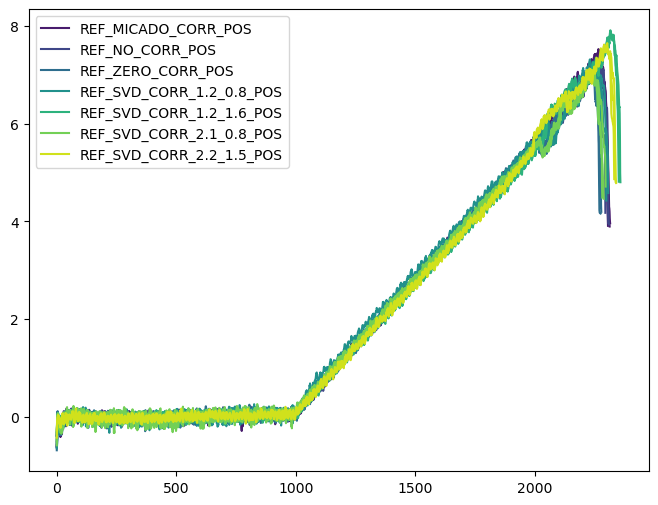

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colormap = colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
bpm_number = 0
for n, key in enumerate(list(bpms_data.keys())):
    if 'POS' in key:
        color = colormap(norm(n))

        for i in range(len(bpms_data[key])):
            if i == 0:
                m = calc_mean(bpms_data[key][i].hor_turn_position[bpm_number], 0, inj_idx)
                bpm = bpms_data[key][i].bpms_hor[bpm_number]
                ax.plot((bpms_data[key][i].hor_turn_position[bpm_number] - m)/tw.rows[bpm].dx[0], label=f'{key}', color=color)
            else:
                m = calc_mean(bpms_data[key][i].hor_turn_position[bpm_number], 0, inj_idx)
                bpm = bpms_data[key][i].bpms_hor[bpm_number]
                ax.plot((bpms_data[key][i].hor_turn_position[bpm_number] - m)/tw.rows[bpm].dx[0], color=color)
ax.legend()

### Plotting sweep vs delta

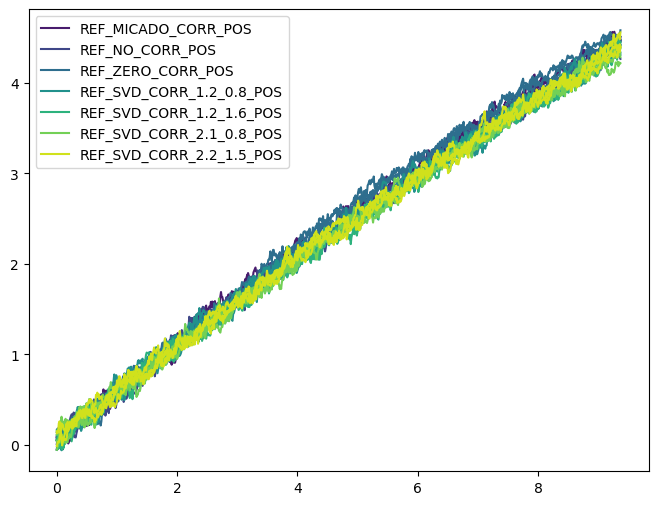

In [94]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colormap = colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
bpm_number = 10
for n, key in enumerate(list(bpms_data.keys())):
    if 'POS' in key:
        color = colormap(norm(n))

        for i in range(len(bpms_data[key])):
            delta_sweep = get_delta_sweep(bpms_data[key][i].hor_turn_position[bpm_number], inj_idx, idx_sweep)
            if i == 0:
                m = calc_mean(bpms_data[key][i].hor_turn_position[bpm_number], 0, inj_idx)
                bpm = bpms_data[key][i].bpms_hor[bpm_number]
                ax.plot(delta_sweep*1e3, (bpms_data[key][i].hor_turn_position[bpm_number][inj_idx:idx_sweep] - m)/tw.rows[bpm].dx[0], label=f'{key}', color=color)
            else:
                m = calc_mean(bpms_data[key][i].hor_turn_position[bpm_number], 0, inj_idx)
                bpm = bpms_data[key][i].bpms_hor[bpm_number]
                ax.plot(delta_sweep*1e3, (bpms_data[key][i].hor_turn_position[bpm_number][inj_idx:idx_sweep] - m)/tw.rows[bpm].dx[0], color=color)
ax.legend()

## Check which bpms are valid
For now, manually

In [111]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
colormap = colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
bpm_number = 0
for bpm_number, bpm in enumerate(bpms_data['REF_MICADO_CORR_POS'][0].bpms_hor):
    if bpm == 'bph.41608':
        continue
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    colormap = colormaps['viridis']
    norm = plt.Normalize(vmin=0, vmax= int(len(list(bpms_data.keys()))))
    for n, key in enumerate(list(bpms_data.keys())):
        if 'POS' in key:
            color = colormap(norm(n))

            for i in range(len(bpms_data[key])):
                if np.isnan(bpms_data[key][i].hor_turn_position[bpm_number])[0]:
                    print(f'Skipping {key} {bpm} {i} because no data')
                    continue
                if i == 0:
                    m = calc_mean(bpms_data[key][i].hor_turn_position[bpm_number], 0, inj_idx)
                    bpm = bpms_data[key][i].bpms_hor[bpm_number]
                    ax.plot((bpms_data[key][i].hor_turn_position[bpm_number] - m)/tw.rows[bpm].dx[0], label=f'{key}', color=color)
                else:
                    m = calc_mean(bpms_data[key][i].hor_turn_position[bpm_number], 0, inj_idx)
                    bpm = bpms_data[key][i].bpms_hor[bpm_number]
                    ax.plot((bpms_data[key][i].hor_turn_position[bpm_number] - m)/tw.rows[bpm].dx[0], color=color)
    ax.legend()
    ax.set_title(f'{bpm}')
    plt.savefig(f'/Users/lisepauwels/sps_simulations/Prototyping/20251209/dispersion_plots/{bpm}.png', dpi=300)
    plt.close('all')

Skipping REF_MICADO_CORR_POS bph.22008 0 because no data
Skipping REF_MICADO_CORR_POS bph.22008 1 because no data
Skipping REF_MICADO_CORR_POS bph.22008 2 because no data
Skipping REF_NO_CORR_POS bph.22008 0 because no data
Skipping REF_NO_CORR_POS bph.22008 1 because no data
Skipping REF_NO_CORR_POS bph.22008 2 because no data
Skipping REF_ZERO_CORR_POS bph.22008 0 because no data
Skipping REF_ZERO_CORR_POS bph.22008 1 because no data
Skipping REF_ZERO_CORR_POS bph.22008 2 because no data
Skipping REF_SVD_CORR_1.2_0.8_POS bph.22008 0 because no data
Skipping REF_SVD_CORR_1.2_0.8_POS bph.22008 1 because no data
Skipping REF_SVD_CORR_1.2_0.8_POS bph.22008 2 because no data
Skipping REF_SVD_CORR_1.2_1.6_POS bph.22008 0 because no data
Skipping REF_SVD_CORR_1.2_1.6_POS bph.22008 1 because no data
Skipping REF_SVD_CORR_1.2_1.6_POS bph.22008 2 because no data
Skipping REF_SVD_CORR_2.1_0.8_POS bph.22008 0 because no data
Skipping REF_SVD_CORR_2.1_0.8_POS bph.22008 1 because no data
Skipping 

/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_5062/2464913418.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Based on the plots, I disregard these BPMs for further analysis:
- bph.11608
- bph.11831
- bph.12008
- bph.13008 (too large oscillation)
- bph.22008
- bph.31608 (too large oscillation)
- bph.31808
- bph.32008
- bph.42008
- bph.43008 (too large oscillation)
- bph.50608
- bph.52008
- bph.53008
- bph.60408 (too large oscillation)
- bph.60608 (too large oscillation)
- bph.61608 (too large oscillation)
- bph.62008
- bph.63008


# Dispersion calculation

Seems very non-linear, and dependant on correction scheme

In [112]:
def fit_pooled(x, ys, deg):
    # ys: list/tuple of arrays [y1, y2, ...], each same length as x
    X = np.concatenate([x]*len(ys))             # length n = m * num_sets
    Y = np.concatenate(ys)
    coefs = np.polyfit(X, Y, deg)               # ordinary least squares
    Yfit = np.polyval(coefs, X)
    RSS = np.sum((Y - Yfit)**2)
    n = len(Y)
    k = deg + 1
    bic = k*np.log(n) + n*np.log(RSS / n)
    return coefs, RSS, bic

In [ ]:
t_sweep = 1.67
t_mid = t_sweep / 2
inj_idx = 1000
idx_sweep = inj_idx + int(t_mid * 1e3)
idx_sweep_th = inj_idx + int(t_sweep * 1e3)

In [114]:
excluded_bpms = ['bph.11608', 'bph.11831', 'bh.12008', 'bph.13008', 
                'bph.22008', 'bph.31608', 'bph.31808', 'bph.32008',
                'bph.42008', 'bph.43008', 'bph.50608', 'bph.52008', 
                'bph.53008', 'bph.60408', 'bph.60608', 'bph.61608',
                'bph.62008', 'bph.63008']

In [ ]:
dispersion_factors = {}
for key in bpms_data:
    dispersion_factors[key] = {}

    if key in ['REF_SVD_CORR_2.2_1.5_NEG']:
        continue
    
    for nn_bpm, bpm in enumerate(bpms_data[key][0].bpms_hor):
        if bpm not in excluded_bpms:
            dispersion_factors[key][bpm] = []
            idx_dead = np.argmax(bpms_data[key][0].hor_turn_position[nn_bpm])
            if idx_dead < idx_sweep:
                idx_stop = idx_dead
                print(key, bpm, 'dead before end of sweep')
            else:
                idx_stop = idx_sweep
            dat = []

            for i in range(len(bpms_data[key])):
                mm = calc_mean(bpms_data[key][i].hor_turn_position[nn_bpm], 0, inj_idx)
                

In [ ]:
dispersion_factors = {}
for key in bpms_data:
    dispersion_factors[key] = {}

    if key in ['REF_SVD_CORR_2.2_1.5_NEG']:
        continue
    for nn_bpm, bpm in enumerate(bpms_data[key][0].bpms_hor):
        dispersion_factors[key][bpm] = []
        idx_max = np.argmax(bpms_data[key][0].hor_turn_position[nn_bpm])
        if idx_max < start_idx:
            print(key, bpm)
            continue
        dat = []
        c = 0
        for i in range(len(bpms_data[key])):
            if len(bpms_data[key][i].hor_turn_position[nn_bpm][start_idx:idx_max]) == 0 or np.isnan(np.unique(bpms_data[key][i].hor_turn_position[nn_bpm])[0]):
                c +=1
            else:
                dat.append(bpms_data[key][i].hor_turn_position[nn_bpm][start_idx:idx_max] - np.nanmean(bpms_data[key][i].hor_turn_position[nn_bpm][injection_idx:start_idx]))
        if c == 3:
            print(key, bpm)
        
        else:
            dr_sweep = np.linspace(0, 32e-3, idx_max-start_idx)
            delta_sweep = dr_to_delta(dr_sweep, tw)
            coefs, RSS, bic = fit_pooled(delta_sweep, dat, deg=2)
            dispersion_factors[key][bpm] = coefs
    # if 'POS' in key:
    #     dispersion_factors[key] = []
    #     for i in range(len(bpms_data[key])):
    #         delta_pos = bpms_data[key][i].hor_turn_position[0][start_idx:] - np.nanmean(bpms_data[key][i].hor_turn_position[0][500:1015])
    #         if i == 0:
    #             ref_pos = delta_pos
    #         dispersion = delta_pos / ref_pos
    #         dispersion_factors[key].append(dispersion)

REF_MICADO_CORR_NEG bph.10208
REF_MICADO_CORR_NEG bph.10408
REF_MICADO_CORR_NEG bph.10608
REF_MICADO_CORR_NEG bph.10808
REF_MICADO_CORR_NEG bph.11008
REF_MICADO_CORR_NEG bph.11208
REF_MICADO_CORR_NEG bph.11408
REF_MICADO_CORR_NEG bph.12208
REF_MICADO_CORR_NEG bph.12408
REF_MICADO_CORR_NEG bph.12608
REF_MICADO_CORR_NEG bph.12808
REF_MICADO_CORR_NEG bph.13008
REF_MICADO_CORR_NEG bph.13208
REF_MICADO_CORR_NEG bph.13408
REF_MICADO_CORR_NEG bph.13608
REF_MICADO_CORR_NEG bph.20208
REF_MICADO_CORR_NEG bph.20408
REF_MICADO_CORR_NEG bph.20608
REF_MICADO_CORR_NEG bph.20808
REF_MICADO_CORR_NEG bph.21008
REF_MICADO_CORR_NEG bph.21208
REF_MICADO_CORR_NEG bph.21408
REF_MICADO_CORR_NEG bph.22008
REF_MICADO_CORR_NEG bph.22208
REF_MICADO_CORR_NEG bph.22408
REF_MICADO_CORR_NEG bph.22608
REF_MICADO_CORR_NEG bph.22808
REF_MICADO_CORR_NEG bph.23008
REF_MICADO_CORR_NEG bph.23208
REF_MICADO_CORR_NEG bph.23408
REF_MICADO_CORR_NEG bph.23608
REF_MICADO_CORR_NEG bph.30208
REF_MICADO_CORR_NEG bph.30408
REF_MICADO